In [1]:
import os
import copy
import torch
import torchvision
from torch.functional import F
from torch.autograd import Variable
import numpy as np

from dataset import PatchDataset
from model import PatchClassifier, ModelHandler
import config
import utils

from PIL import Image
import matplotlib.pyplot as plt

import lovely_tensors as lt

In [2]:
def getGaussianFilter(ksize):
    return torchvision.transforms.GaussianBlur((ksize,ksize))

def preprocess_image(arr):
    return Variable(torch.unsqueeze(config.ATF['tn'](image=arr)['image'], dim=0), requires_grad=True)
    
def recreate_image(tensor, clip=False):
    if clip:
        img = torch.squeeze(tensor.clip(0, 1)).data.numpy()
    else:
        img = torch.squeeze(tensor).data.numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = img * 255
    img = np.uint8(img).transpose(1, 2, 0)
    return img

def plot_generated_results(imgs, cls_label, probs):
    ROW_IMG = len(imgs)
    N_ROWS = 1
    SF = 5

    fig = plt.figure(figsize=(SF * ROW_IMG, SF * N_ROWS))
    for index in range(1, ROW_IMG * N_ROWS + 1):
        img_idx = index - 1
        plt.subplot(N_ROWS, ROW_IMG, index)
        plt.title(f"{cls_label}: {probs[img_idx]:.2f}")
        plt.axis('off')
        plt.imshow(imgs[img_idx])

class ClassSpecificImageGeneration():
    """
        Produces an image that maximizes a certain class with gradient ascent
    """
    def __init__(self, model, target_class, momentum=0.9, lr=6, iterations=150, gfilter=None, filter_freq=5, 
                n_res=10, if_clip=True):
        
        self.model = model
        self.model.eval()
        
        self.target_class = target_class
        self.learning_rate = lr
        self.iterations = iterations
        self.gfilter = gfilter
        self.filter_freq = filter_freq
        self.n_res = n_res
        self.if_clip = if_clip
        self.created_image = np.uint8(np.random.uniform(0, 255, (224, 224, 3)))
        self.results = None
        self.loss = None
        self.momentum = momentum
        

    def generate(self, verbose=True):
        """Generates class specific image
        Returns:
            np.ndarray -- Final maximally activated class image
        """
        self.results = []
        self.loss = []
        snap_iter = self.iterations // self.n_res
        for i in range(1, self.iterations + 1):
            # Process image and return variable
            self.processed_image = preprocess_image(self.created_image)
            # Define optimizer for the image
            optimizer = torch.optim.SGD([self.processed_image], lr=self.learning_rate, momentum=self.momentum)
            # Forward
            output = self.model(self.processed_image)
            # Target specific class
            class_loss = -output[0, self.target_class]
            
            self.loss.append(class_loss.data.numpy())
            if verbose:
                if i % 10 == 0 or i == self.iterations:
                    print('Iteration:', str(i), 'Loss',
                          "{0:.2f}".format(class_loss.data.numpy()))
            # Zero grads
            self.model.zero_grad()
            # Backward
            class_loss.backward()
            # Update image
            optimizer.step()
            
            # Regularize with gaussian filter
            if i % self.filter_freq == 0 and self.gfilter is not None:
                self.processed_image = self.gfilter(self.processed_image)
            
            # Recreate image
            self.created_image = recreate_image(self.processed_image, clip=if_clip)
            
            if i % snap_iter == 0:
                self.results.append(self.created_image)
                
            if i == 1:
                first = self.created_image
                
            if i == self.iterations:
                last = self.created_image 
                
        self.results[0] = first
        self.results[-1] = last

In [3]:
INF_DICE = 88.24

mh = ModelHandler(
    PatchClassifier(
        features_only=config.FEATURES_ONLY, 
        out_classes=config.NUM_CLASSES,
        freeze_encoder=config.FREEZE_ENCODER)
)
mh.load(os.path.join(config.MODEL_FOLDER, f'{config.CONFIG_ID}_{INF_DICE}.pt'))

infer_model = copy.deepcopy(mh.model.model)
model = copy.deepcopy(mh.model.model)

infer_model.eval()
model.requires_grad_(True)
model.eval()

ref_dataset = PatchDataset(config.DATA_DIR, config.ATF, preproc=False, augment=False)
dataset = PatchDataset(config.DATA_DIR, config.ATF, preproc=True, augment=False)

Iteration: 10 Loss 1.26
Iteration: 20 Loss 1.26
Iteration: 30 Loss 1.26
Iteration: 40 Loss 1.26
Iteration: 50 Loss 1.26
Iteration: 60 Loss 1.26
Iteration: 70 Loss 1.26
Iteration: 80 Loss 1.26
Iteration: 90 Loss 1.26
Iteration: 100 Loss 1.26
Iteration: 110 Loss 1.72
Iteration: 120 Loss 1.72
Iteration: 130 Loss 1.72
Iteration: 140 Loss 1.72
Iteration: 150 Loss 1.72
Iteration: 160 Loss 1.72
Iteration: 170 Loss 1.72
Iteration: 180 Loss 1.72
Iteration: 190 Loss 1.72
Iteration: 200 Loss 1.72
Iteration: 210 Loss 2.14
Iteration: 220 Loss 2.14
Iteration: 230 Loss 2.14
Iteration: 240 Loss 2.14
Iteration: 250 Loss 2.14
Iteration: 260 Loss 2.14
Iteration: 270 Loss 2.14
Iteration: 280 Loss 2.14
Iteration: 290 Loss 2.14
Iteration: 300 Loss 2.14
Iteration: 10 Loss 0.72
Iteration: 20 Loss 0.72
Iteration: 30 Loss 0.72
Iteration: 40 Loss 0.72
Iteration: 50 Loss 0.72
Iteration: 60 Loss 0.72
Iteration: 70 Loss 0.72
Iteration: 80 Loss 0.72
Iteration: 90 Loss 0.72
Iteration: 100 Loss 0.72
Iteration: 110 Los

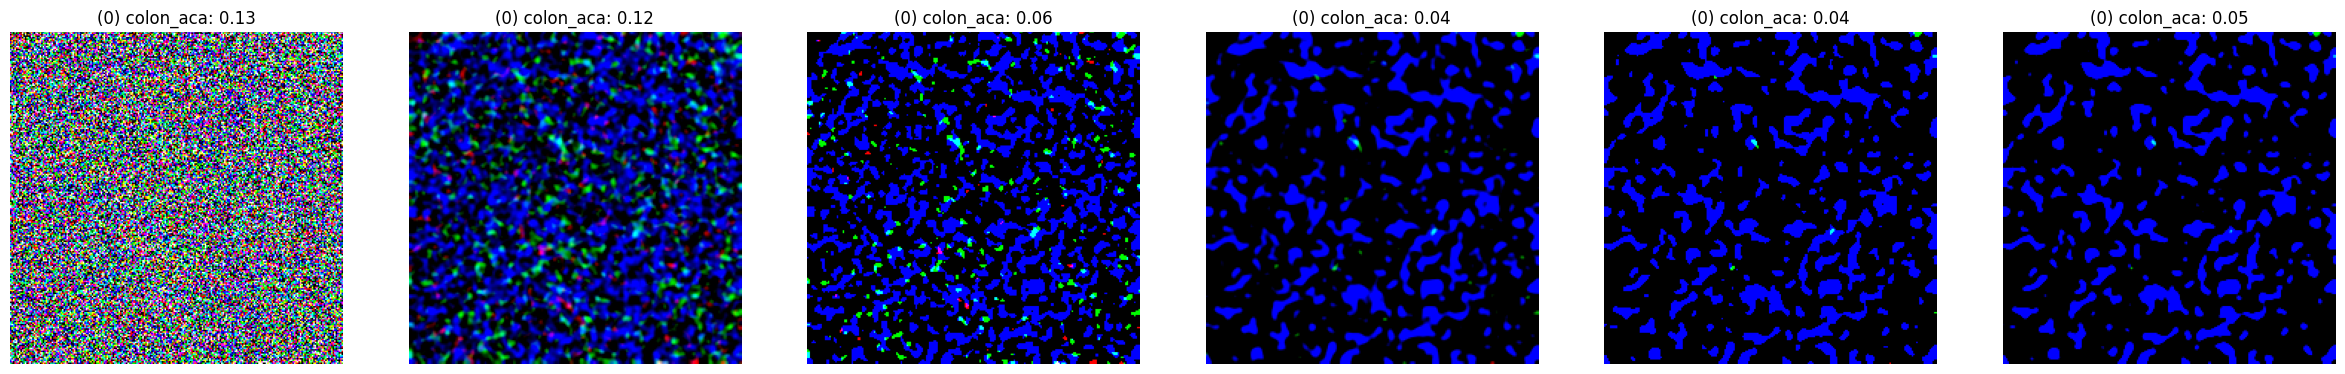

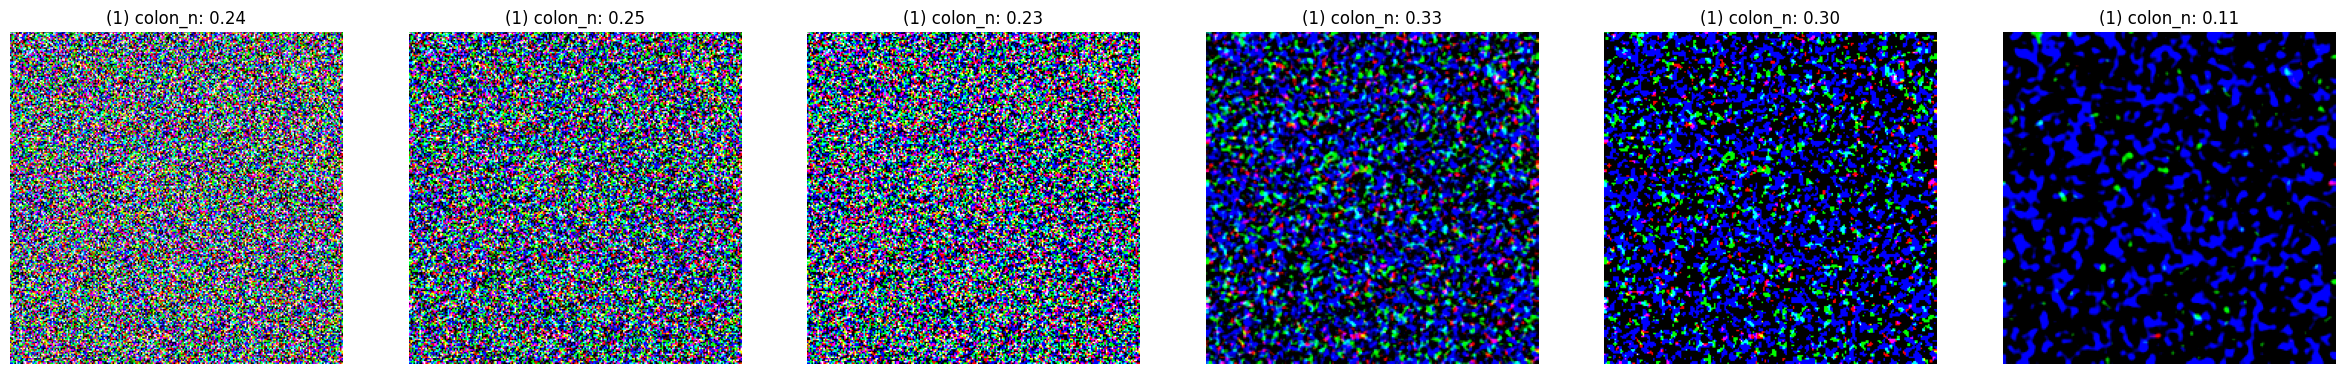

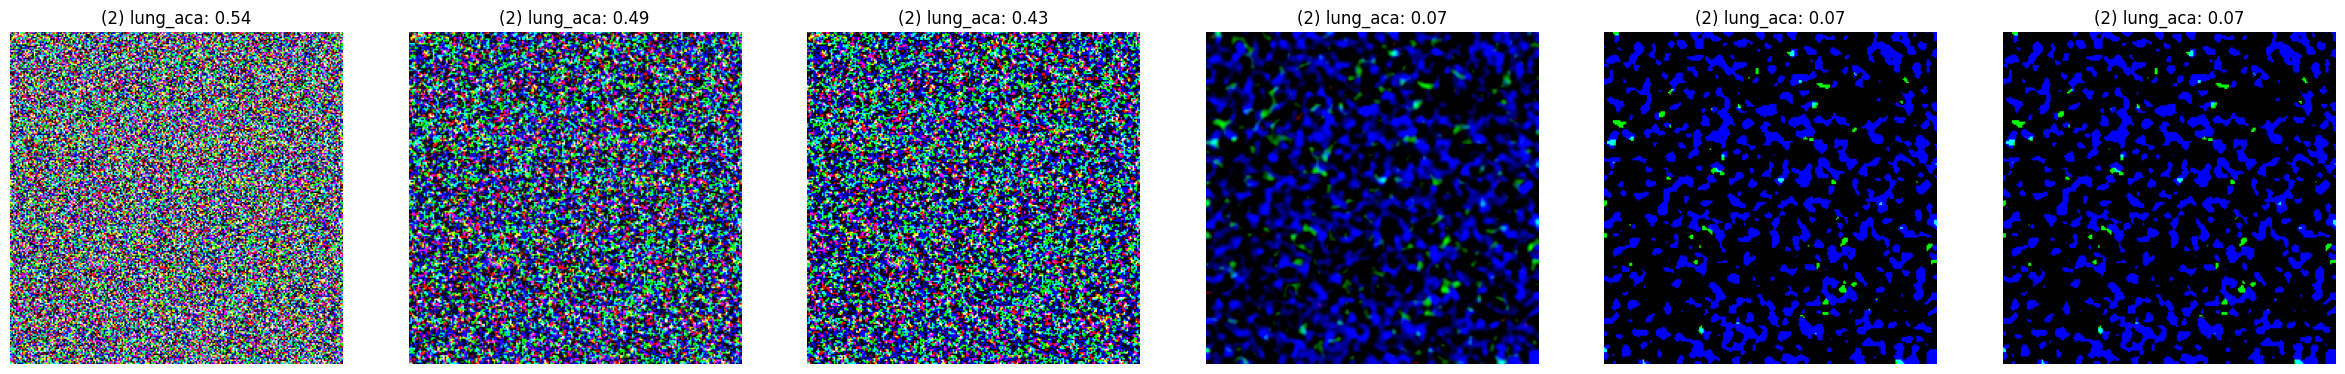

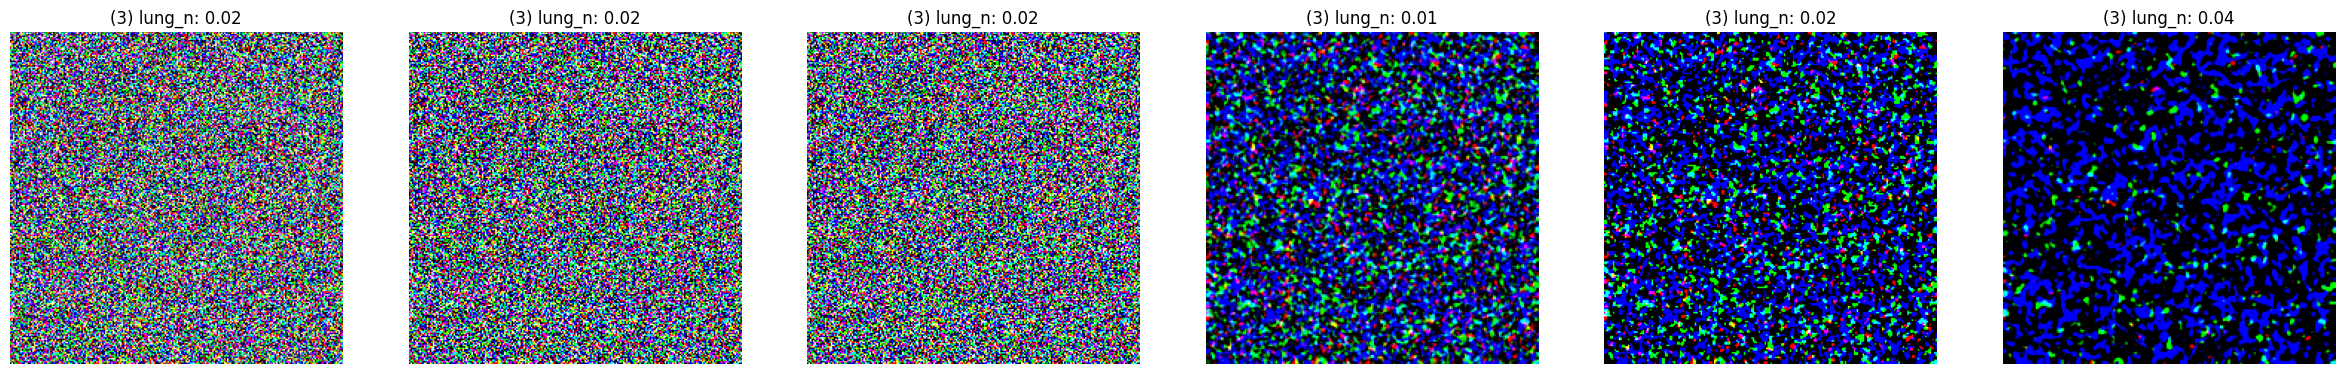

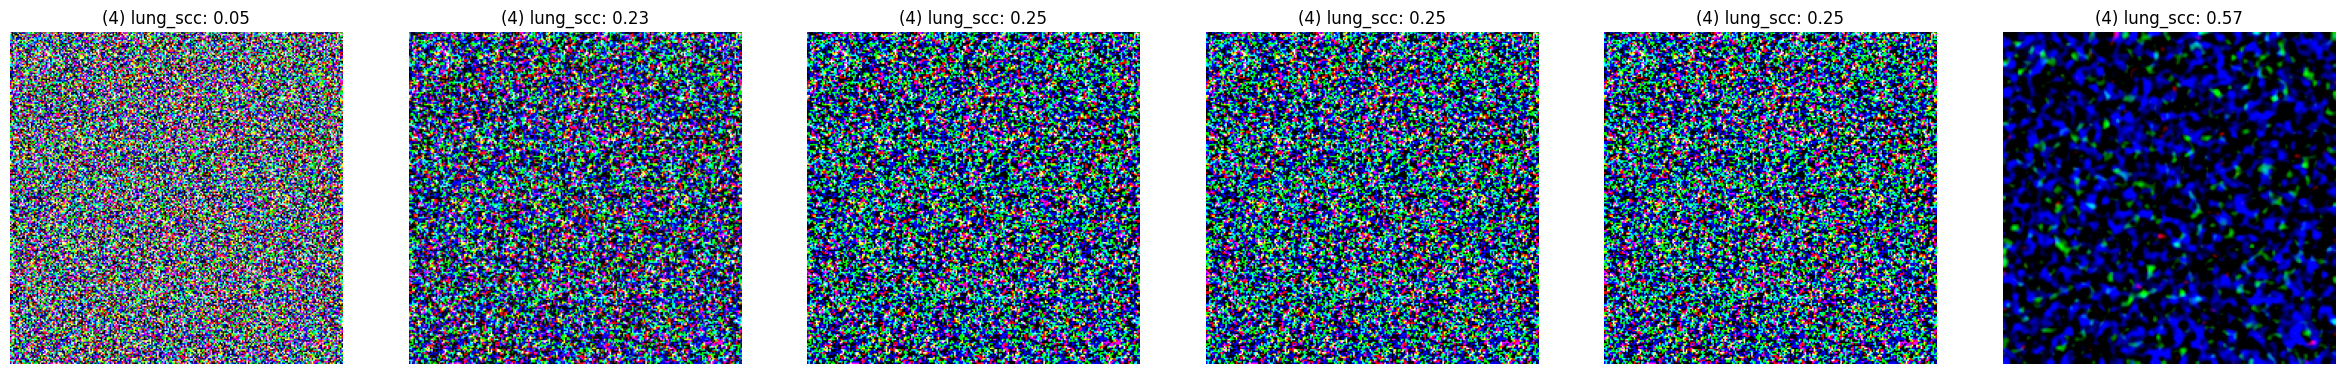

In [4]:
for target_class in dataset.idx_to_class.keys():

    lr = 5
    iterations = 300
    n_images_to_gen = 6
    gaussian_filter = getGaussianFilter(15)
    filter_freq = 100
    if_clip = True

    csig = ClassSpecificImageGeneration(model, target_class, lr=lr, iterations=iterations, gfilter=gaussian_filter, 
                    filter_freq=filter_freq, n_res=n_images_to_gen, if_clip=if_clip)
    csig.generate()

    probs = []
    for in_tensor in [torch.unsqueeze(config.ATF['tn'](image=im)['image'], dim=0) for im in csig.results]:
        probs.append(F.softmax(infer_model(in_tensor), dim=1)[0, target_class].item())

    plot_generated_results(csig.results, 
                cls_label=f"({target_class}) {dataset.idx_to_class[target_class]}",
                probs=probs
                )